In [178]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def f(inputs):
    dim = int(inputs.size()[0]/2)
    print(dim)
    x = inputs[:dim]
    y = inputs[dim:]
    return 2*x**2 + y**2 + x*y
    
#x = torch.linspace(-1,1,100)
#y = torch.linspace(-1,1,100)

x = torch.rand([])
y = torch.rand([])

ins = torch.tensor([x,y])
print(ins)
print(4*ins[0] +ins[1])
#ins = torch.cat((x,y))
out = torch.func.vjp(f,ins)


out_jacrev = torch.func.jacfwd(f,argnums=0)(ins)
print(out_jacrev[0])

tensor([0.5242, 0.8574])
tensor(2.9541)
1
1
tensor([2.9541, 2.2390])


In [224]:
def f(inp):
    x = inp[:-2]
    param = inp[-2:]
    return param*torch.sum(x**2)

x = torch.rand([5])
print(x)

out_jacrev = torch.func.jacfwd(f,argnums=0)(x)
print(out_jacrev.sum(axis=0)/x)
print(2*(x[-2]+x[-1]))

tensor([0.7513, 0.6792, 0.9733, 0.4389, 0.6509])
tensor([2.1797, 2.1797, 2.1797, 4.4951, 3.0313])
tensor(2.1797)


In [260]:
def f(x,y,param):
    return param*torch.sum(x**2 + y**2 + x*y)

x = torch.tensor([1,2,3,5.])
y = torch.tensor([7,11,13,17.])
param = torch.tensor([1.])

print(torch.sum(x**2+y**2+x*y))

out_jacrev = torch.func.jacfwd(f,argnums=0)(x,y,param)
print(out_jacrev.sum(axis=0))

tensor(820.)
tensor([ 9., 15., 19., 27.])


100%|██████████| 1000/1000 [00:02<00:00, 341.65it/s]


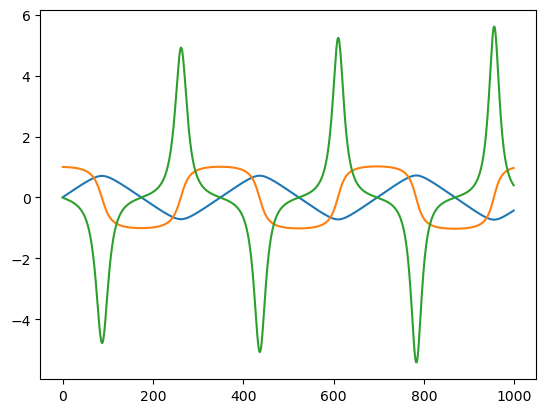

In [396]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import tqdm

def L(q,qdot,m,k,alpha):
    return 0.5*m*qdot**2 - 0.5*k*q**2 - alpha*q**2*qdot**2

"""
q = torch.tensor([1,2,3.])
qdot = torch.tensor([11,7,5.])
m = 1*torch.ones_like(q)
k = 2*torch.ones_like(q)
alpha = .2*torch.ones_like(q)
"""
"""
q = torch.tensor([1.1,1.3])
qdot = torch.tensor([2.3,2.5])
m = 1*torch.ones_like(q)
k = 2*torch.ones_like(q)
alpha = .2*torch.ones_like(q)
"""

its = 1000
dt = 0.01

qhist = torch.zeros(its)
qdothist = torch.zeros(its)
qddothist = torch.zeros(its)

q = torch.tensor([0],dtype=torch.float64)
qdot = torch.tensor([1],dtype=torch.float64)
m = 1*torch.ones_like(q)
k = 2*torch.ones_like(q)
alpha = 0.7*torch.ones_like(q)

g_q = torch.vmap(torch.func.jacfwd(L,argnums=0))
g_qdot = torch.vmap(torch.func.jacfwd(L,argnums=1))

g_q_qdot = (torch.func.jacfwd(g_qdot,argnums=0))
g_qdot_q = (torch.func.jacfwd(g_q,argnums=1))
g_qdot_qdot = (torch.func.jacfwd(g_qdot,argnums=1))

for i in tqdm.trange(its):
    q.data += dt*qdot
    #g_q = torch.vmap(torch.func.jacfwd(L,argnums=0))
    #g_qdot = torch.vmap(torch.func.jacfwd(L,argnums=1))
    
    #print(gq(q,qdot,m,k))
    t_g_q_qdot = g_q_qdot(q,qdot,m,k,alpha)
    t_g_qdot_q = g_qdot_q(q,qdot,m,k,alpha)
    t_g_qdot_qdot = g_qdot_qdot(q,qdot,m,k,alpha)
    
    D = torch.linalg.inv(t_g_qdot_qdot)
    #print(g_q(q,qdot,m,k,alpha))
    
    qddot = D@(g_q(q,qdot,m,k,alpha) - t_g_q_qdot@qdot)
    #q.data += dt*qdot
    qdot.data += dt*qddot

    qhist[i] = q.data
    qdothist[i] = qdot.data
    qddothist[i] = qddot.data

plt.plot(qhist)
plt.plot(qdothist)
plt.plot(qddothist)

100%|██████████| 500/500 [00:01<00:00, 396.44it/s]


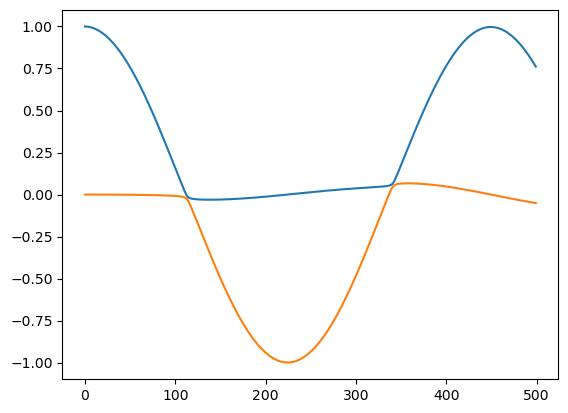

In [34]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import tqdm

def L(q,qdot,m,k,alpha):
    return torch.sum(0.5*m*qdot**2) - torch.sum(0.5*k*q**2) - alpha*torch.sum( torch.sqrt(1/( (q[0]-q[1])**2 )) )

"""
q = torch.tensor([1,2,3.])
qdot = torch.tensor([11,7,5.])
m = 1*torch.ones_like(q)
k = 2*torch.ones_like(q)
alpha = .2*torch.ones_like(q)
"""

q = torch.tensor([1.0,0],dtype=torch.float64)
qdot = torch.tensor([0,0],dtype=torch.float64)
#m = 1*torch.ones_like(q)
#k = 2*torch.ones_like(q)
#alpha = .01*torch.ones_like(q)
m = torch.tensor([1],dtype=torch.float64)
k = torch.tensor([2],dtype=torch.float64)
alpha = torch.tensor([.01],dtype=torch.float64)

its = 500
dt = 0.01

qhist = torch.zeros([2,its])
qdothist = torch.zeros([2,its])
qddothist = torch.zeros([2,its])

#print(L(q,qdot,m,k,alpha))

"""
g_q = torch.vmap(torch.func.jacfwd(L,argnums=0) )
g_qdot = torch.vmap(torch.func.jacfwd(L,argnums=1))

g_q_qdot = (torch.func.jacfwd(g_qdot,argnums=0))
g_qdot_q = (torch.func.jacfwd(g_q,argnums=1))
g_qdot_qdot = (torch.func.jacfwd(g_qdot,argnums=1))
"""

g_q = (torch.func.jacfwd(L,argnums=0) )
g_qdot = (torch.func.jacfwd(L,argnums=1))

g_q_qdot = (torch.func.jacfwd(g_qdot,argnums=0))
g_qdot_q = (torch.func.jacfwd(g_q,argnums=1))
g_qdot_qdot = (torch.func.jacfwd(g_qdot,argnums=1))

#print(g_q(q,qdot,m,k,alpha))

for i in tqdm.trange(its):
    q.data += dt*qdot

    t_g_q_qdot = g_q_qdot(q,qdot,m,k,alpha)
    t_g_qdot_q = g_qdot_q(q,qdot,m,k,alpha)
    t_g_qdot_qdot = g_qdot_qdot(q,qdot,m,k,alpha)
    
    D = torch.linalg.inv(t_g_qdot_qdot)[0]
    #print(D@(t_g_q_qdot@(qdot)).T)

    qddot = (D@g_q(q,qdot,m,k,alpha).T - D@(t_g_q_qdot@(qdot)).T).reshape(-1)
    qdot.data += dt*qddot

    qhist[:,i] = q.data
    qdothist[:,i] = qdot.data
    qddothist[:,i] = qddot.data

plt.plot(qhist[0,:])
plt.plot(qhist[1,:]) 
#plt.plot(qdothist)
#plt.plot(qddothist)


In [36]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import tqdm

n_points = 5
q_min = -1
q_max = 1
qdot_min = -1
qdot_max = 1

def L(q,qdot,m,k,alpha):
    return 0.5*m*qdot**2 - 0.5*k*q**2 - alpha*q**2*qdot**2



qgrid = torch.linspace(q_min,q_max,n_points)
qdotgrid = torch.linspace(qdot_min,qdot_max,n_points)

Q, QD = torch.meshgrid(qgrid, qdotgrid)

im = 0*torch.outer(qgrid,qdotgrid)

m = torch.tensor([1],dtype=torch.float64)
k = torch.tensor([2],dtype=torch.float64)
alpha = torch.tensor([0],dtype=torch.float64)

g_q = (torch.func.jacfwd(L,argnums=0))
g_qdot = (torch.func.jacfwd(L,argnums=1))

g_q_qdot = torch.func.jacfwd(g_qdot,argnums=0)
g_qdot_q = torch.func.jacfwd(g_q,argnums=1)
#torch.vmap(torch.func.jacfwd(g_q,argnums=1),in_dims=(0,0,None,None,None))
g_qdot_qdot = torch.func.jacfwd(g_qdot,argnums=1)
#torch.vmap(torch.func.jacfwd(g_qdot,argnums=1),in_dims=(0,0,None,None,None))

t_g_q_qdot = g_q_qdot(Q,QD,m,k,alpha)
t_g_qdot_q = g_qdot_q(Q,QD,m,k,alpha)
t_g_qdot_qdot = g_qdot_qdot(Q,QD,m,k,alpha)

D = t_g_qdot_qdot**(-1)
#print(g_q(q,qdot,m,k,alpha))

print(t_g_qdot_q)
D*g_q(Q,QD,m,k,alpha)# - D*t_g_q_qdot*QD
#im = D*(g_q(Q,QD,m,k,alpha) - t_g_q_qdot*QD)

"""
for i in tqdm.trange(n_points):
    for j in range(n_points):

        t_g_q_qdot = g_q_qdot(qgrid[i],qdotgrid[j],m,k,alpha)
        t_g_qdot_q = g_qdot_q(qgrid[i],qdotgrid[j],m,k,alpha)
        t_g_qdot_qdot = g_qdot_qdot(qgrid[i],qdotgrid[j],m,k,alpha)
        
        D = t_g_qdot_qdot**(-1)
        #print(g_q(q,qdot,m,k,alpha))
        
        im[i,j] = D*(g_q(qgrid[i],qdotgrid[j],m,k,alpha) - t_g_q_qdot*qdotgrid[j])
"""        
plt.imshow(im)


RuntimeError: unsupported operation: more than one element of the written-to tensor refers to a single memory location. Please clone() the tensor before performing the operation.

100%|██████████| 50/50 [00:07<00:00,  7.12it/s]


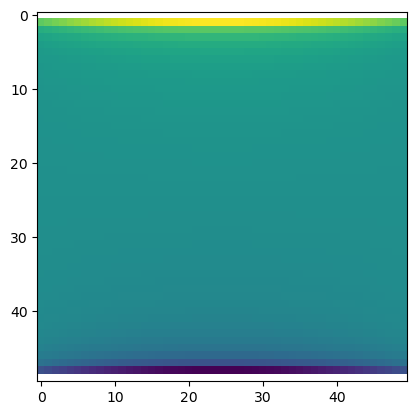

In [6]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import tqdm
from torch.func import jacfwd
import time

m = torch.tensor([1],dtype=torch.float64)
k = torch.tensor([2],dtype=torch.float64)
alpha = torch.tensor([0.5],dtype=torch.float64)

n_points = 50
q_min = -1
q_max = 1
qdot_min = -1
qdot_max = 1

def L(q,qdot,m,k,alpha):
    return 0.5*m*qdot**2 - 0.5*k*q**2 - alpha*q**2*qdot**2



qgrid = torch.linspace(q_min,q_max,n_points)
qdotgrid = torch.linspace(qdot_min,qdot_max,n_points)

#Q, QD = torch.meshgrid(qgrid, qdotgrid)

im = 0*torch.outer(qgrid,qdotgrid)


g_q = jacfwd(L,argnums=0)
g_qdot = jacfwd(L,argnums=1)

#g_q_qdot = torch.func.jacfwd(g_qdot,argnums=0)
#g_qdot_q = torch.func.jacfwd(g_q,argnums=1)



#g_qdot_qdot = torch.func.jacfwd(g_qdot,argnums=1)

g_q_qdot = jacfwd(jacfwd(L,argnums=1),argnums=0)
g_qdot_q = jacfwd(jacfwd(L,argnums=0),argnums=1)
g_qdot_qdot = jacfwd(jacfwd(L,argnums=1),argnums=1)



#D = t_g_qdot_qdot**(-1)
#print(g_q(q,qdot,m,k,alpha))

#print(t_g_qdot_q)
#D*g_q(Q,QD,m,k,alpha)# - D*t_g_q_qdot*QD
#im = D*(g_q(Q,QD,m,k,alpha) - t_g_q_qdot*QD)


for i in tqdm.trange(n_points):
    for j in range(n_points):

        t_g_q_qdot = g_q_qdot(qgrid[i],qdotgrid[j],m,k,alpha)
        t_g_qdot_q = g_qdot_q(qgrid[i],qdotgrid[j],m,k,alpha)
        t_g_qdot_qdot = g_qdot_qdot(qgrid[i],qdotgrid[j],m,k,alpha)
        
        D = t_g_qdot_qdot**(-1)
        #print(g_q(q,qdot,m,k,alpha))
        
        im[i,j] = D*(g_q(qgrid[i],qdotgrid[j],m,k,alpha) - t_g_q_qdot*qdotgrid[j])
   
plt.imshow(im)


100%|██████████| 2000/2000 [00:06<00:00, 305.30it/s]

6.552120208740234


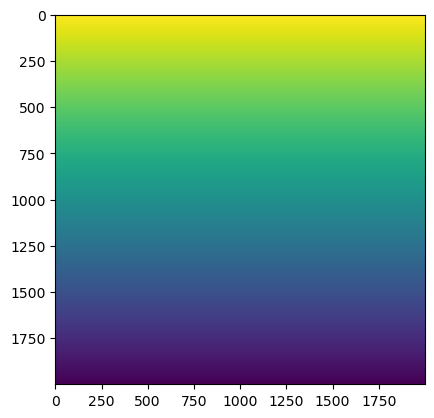

In [6]:
#trying to add vmap functionality, base func.jacfwd appears to be a lot slower than calcuating the full jacobians/Hessians.


import torch
import numpy as np
import matplotlib.pyplot as plt
import tqdm
from torch.func import jacfwd, vmap
import time

m = torch.tensor([1],dtype=torch.float64)
k = torch.tensor([2],dtype=torch.float64)
alpha = torch.tensor([0.0],dtype=torch.float64)

n_points = 2000
q_min = -1
q_max = 1
qdot_min = -1
qdot_max = 1

def L(q,qdot,m,k,alpha):
    return 0.5*m*qdot**2 - 0.5*k*q**2 - alpha*q**2*qdot**2



qgrid = torch.linspace(q_min,q_max,n_points)
qdotgrid = torch.linspace(qdot_min,qdot_max,n_points)
Q = torch.tensor([])
QD = torch.tensor([])
for i in range(n_points):
    Q = torch.concat((Q,qgrid))
    QD = torch.concat((QD,qdotgrid[i]*torch.ones(n_points)))

im = 0*torch.zeros([n_points,n_points])
#print(im.shape)

tic_for = time.time()
g_q = vmap(jacfwd(L,argnums=0),in_dims=(0,None,None,None,None))
g_qdot = vmap(jacfwd(L,argnums=1),in_dims=(0,None,None,None,None))

g_q_qdot = vmap(jacfwd(jacfwd(L,argnums=1),argnums=0),in_dims=(0,None,None,None,None))
g_qdot_q = vmap(jacfwd(jacfwd(L,argnums=0),argnums=1),in_dims=(0,None,None,None,None))
g_qdot_qdot = vmap(jacfwd(jacfwd(L,argnums=1),argnums=1),in_dims=(0,None,None,None,None))




for j in tqdm.trange(n_points):
    t_g_q = g_q(qgrid,qdotgrid[j],m,k,alpha)
    t_g_q_qdot = g_q_qdot(qgrid,qdotgrid[j],m,k,alpha)
    t_g_qdot_q = g_qdot_q(qgrid,qdotgrid[j],m,k,alpha)
    t_g_qdot_qdot = g_qdot_qdot(qgrid,qdotgrid[j],m,k,alpha)
    
    D = t_g_qdot_qdot**(-1)

    temp = torch.squeeze(D*(t_g_q - t_g_q_qdot*qdotgrid[j]))
    #print(temp)
    #print(temp.shape)
    #print(im[:,j].shape)
    #print(im[j,:].expand([1,50]))
    im[:,j] = torch.squeeze(D*(t_g_q - t_g_q_qdot*qdotgrid[j]))
    #print(im[:,j])

t_elapsed_for = time.time()-tic_for

in_d = (0,None,None,None,None)
tic_batch = time.time()



#vectorize further... nope, super slow. see next cell!
"""
g_q1 = vmap(jacfwd(L,argnums=0),in_dims=in_d)
g_qdot1 = vmap(jacfwd(L,argnums=1),in_dims=in_d)

g_q_qdot1 = vmap(jacfwd(jacfwd(L,argnums=1),argnums=0),in_dims=in_d)
g_qdot_q1 = vmap(jacfwd(jacfwd(L,argnums=0),argnums=1),in_dims=in_d)
g_qdot_qdot1 = vmap(jacfwd(jacfwd(L,argnums=1),argnums=1),in_dims=in_d)

t_g_q1 = g_q1(Q,QD,m,k,alpha).squeeze()[:,0]
t_g_q_qdot1 = g_q_qdot1(Q,QD,m,k,alpha).squeeze()[0].sum(axis=0)
t_g_qdot_q1 = g_qdot_q1(Q,QD,m,k,alpha).squeeze()[0].sum(axis=0)
t_g_qdot_qdot1 = g_qdot_qdot(Q,QD,m,k,alpha)[0].sum(axis=0).sum(axis=0)
#print(g_qdot_qdot(Q,QD,m,k,alpha))
#print(t_g_q1)



#print(t_g_qdot_qdot1.shape)
D1 = (t_g_qdot_qdot1)**(-1)


#temp = torch.squeeze(D1*(t_g_q1 - t_g_q_qdot1*QD))
#im1 = torch.diagonal((D1*(t_g_q1 - t_g_q_qdot1*QD))).reshape([n_points,n_points]).T
im1 = ( D1*(t_g_q1- t_g_q_qdot1*QD) ).reshape([n_points,n_points]).T

#print(im1)

t_elapsed_batch = time.time() - tic_batch

#print(im1.shape)



"""
"""
for i in tqdm.trange(n_points):
    for j in range(n_points):

        t_g_q_qdot = g_q_qdot(qgrid[i],qdotgrid[j],m,k,alpha)
        t_g_qdot_q = g_qdot_q(qgrid[i],qdotgrid[j],m,k,alpha)
        t_g_qdot_qdot = g_qdot_qdot(qgrid[i],qdotgrid[j],m,k,alpha)
        
        D = t_g_qdot_qdot**(-1)
        #print(g_q(q,qdot,m,k,alpha))
        
        im[i,j] = D*(g_q(qgrid[i],qdotgrid[j],m,k,alpha) - t_g_q_qdot*qdotgrid[j])
"""

print(t_elapsed_for)


plt.imshow(im)
plt.show()
#print(im1)

0.08146405220031738


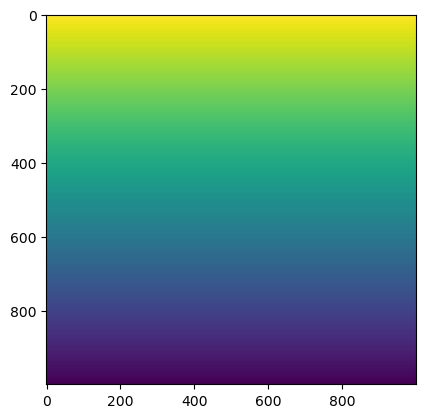

In [10]:
#####
# try a different approach to vectorization? So much faster!

import torch
import numpy as np
import matplotlib.pyplot as plt
import tqdm
from torch.func import jacfwd, vmap
import time

m = torch.tensor([1],dtype=torch.float64)
k = torch.tensor([2],dtype=torch.float64)
alpha = torch.tensor([0.0],dtype=torch.float64)

n_points = 1000
q_min = -1
q_max = 1
qdot_min = -1
qdot_max = 1

def L(q,qdot,m,k,alpha):
    return 0.5*m*qdot**2 - 0.5*k*q**2 - alpha*q**2*qdot**2



qgrid = torch.linspace(q_min,q_max,n_points) #(n_points)
qdotgrid = torch.linspace(qdot_min,qdot_max,n_points) #(n_points)

#define flattened q, qdot arrays (n_points^2), (n_points^2)
Q = torch.tensor([])
QD = torch.tensor([])

for i in range(n_points):
    Q = torch.concat((Q,qgrid))
    QD = torch.concat((QD,qdotgrid[i]*torch.ones(n_points)))

im = 0*torch.zeros([n_points,n_points])
#print(im.shape)


g_q2 = vmap(jacfwd(L,argnums=0),in_dims=(0,None,None,None,None))
g_qdot2 = vmap(jacfwd(L,argnums=1),in_dims=(0,None,None,None,None))

g_q_qdot2 = vmap(jacfwd(jacfwd(L,argnums=1),argnums=0),in_dims=(0,None,None,None,None))
g_qdot_q2 = vmap(jacfwd(jacfwd(L,argnums=0),argnums=1),in_dims=(0,None,None,None,None))
g_qdot_qdot2 = vmap(jacfwd(jacfwd(L,argnums=1),argnums=1),in_dims=(0,None,None,None,None))

def QDD(Q,QD,m,k,alpha):
    g_q2 = jacfwd(L,argnums=0)(Q,QD,m,k,alpha)
    g_qdot2 = jacfwd(L,argnums=1)(Q,QD,m,k,alpha)
    
    g_q_qdot2 = jacfwd(jacfwd(L,argnums=1),argnums=0)(Q,QD,m,k,alpha)
    g_qdot_q2 = jacfwd(jacfwd(L,argnums=0),argnums=1)(Q,QD,m,k,alpha)
    g_qdot_qdot2 = jacfwd(jacfwd(L,argnums=1),argnums=1)(Q,QD,m,k,alpha)
    D = g_qdot_qdot2**(-1)
    return D*(g_q2 - g_q_qdot2*QD)

tic_v2 = time.time()


QDDv = vmap(QDD,in_dims=(0,0,None,None,None))

im = QDDv(Q,QD,m,k,alpha).reshape([n_points,n_points]).T

t_elapsed_v2 = time.time()-tic_v2
print(t_elapsed_v2)

#print(im.shape)

plt.imshow(im)

In [15]:
#speed comparisons

import torch
import numpy as np
import matplotlib.pyplot as plt
import tqdm
from torch.func import jacfwd, vmap
import time

m = torch.tensor([1],dtype=torch.float64)
k = torch.tensor([2],dtype=torch.float64)
alpha = torch.tensor([0.0],dtype=torch.float64)

n_steps_power = 65
n_points_array_powers = np.flip(np.linspace(1,13,n_steps_power))
n_points_array = np.floor(2**n_points_array_powers)

q_min = -1
q_max = 1
qdot_min = -1
qdot_max = 1

torch.set_num_threads(6)

def L(q,qdot,m,k,alpha):
    return 0.5*m*qdot**2 - 0.5*k*q**2 - alpha*q**2*qdot**2

####
# v1 function definition
g_q = vmap(jacfwd(L,argnums=0),in_dims=(0,None,None,None,None))
g_qdot = vmap(jacfwd(L,argnums=1),in_dims=(0,None,None,None,None))

g_q_qdot = vmap(jacfwd(jacfwd(L,argnums=1),argnums=0),in_dims=(0,None,None,None,None))
g_qdot_q = vmap(jacfwd(jacfwd(L,argnums=0),argnums=1),in_dims=(0,None,None,None,None))
g_qdot_qdot = vmap(jacfwd(jacfwd(L,argnums=1),argnums=1),in_dims=(0,None,None,None,None))

#####
# v2 function definition
g_q2 = vmap(jacfwd(L,argnums=0),in_dims=(0,None,None,None,None))
g_qdot2 = vmap(jacfwd(L,argnums=1),in_dims=(0,None,None,None,None))

g_q_qdot2 = vmap(jacfwd(jacfwd(L,argnums=1),argnums=0),in_dims=(0,None,None,None,None))
g_qdot_q2 = vmap(jacfwd(jacfwd(L,argnums=0),argnums=1),in_dims=(0,None,None,None,None))
g_qdot_qdot2 = vmap(jacfwd(jacfwd(L,argnums=1),argnums=1),in_dims=(0,None,None,None,None))

def QDD(Q,QD,m,k,alpha):
    g_q2 = jacfwd(L,argnums=0)(Q,QD,m,k,alpha)
    g_qdot2 = jacfwd(L,argnums=1)(Q,QD,m,k,alpha)
    
    g_q_qdot2 = jacfwd(jacfwd(L,argnums=1),argnums=0)(Q,QD,m,k,alpha)
    g_qdot_q2 = jacfwd(jacfwd(L,argnums=0),argnums=1)(Q,QD,m,k,alpha)
    g_qdot_qdot2 = jacfwd(jacfwd(L,argnums=1),argnums=1)(Q,QD,m,k,alpha)
    D = g_qdot_qdot2**(-1)
    return D*(g_q2 - g_q_qdot2*QD)
        
ts_v1 = torch.zeros(n_steps_power)

for k in tqdm.trange(n_steps_power):
    n_points = int(n_points_array[k])
    qgrid = torch.linspace(q_min,q_max,n_points)
    qdotgrid = torch.linspace(qdot_min,qdot_max,n_points)
    Q = torch.tensor([])
    QD = torch.tensor([])
    im = 0*torch.zeros([n_points,n_points])
    #print(im.shape)
    
    tic_for = time.time()
    
    
    for j in range(n_points):
        t_g_q = g_q(qgrid,qdotgrid[j],m,k,alpha)
        t_g_q_qdot = g_q_qdot(qgrid,qdotgrid[j],m,k,alpha)
        t_g_qdot_q = g_qdot_q(qgrid,qdotgrid[j],m,k,alpha)
        t_g_qdot_qdot = g_qdot_qdot(qgrid,qdotgrid[j],m,k,alpha)
        
        D = t_g_qdot_qdot**(-1)
    
        temp = torch.squeeze(D*(t_g_q - t_g_q_qdot*qdotgrid[j]))
        #print(temp)
        #print(temp.shape)
        #print(im[:,j].shape)
        #print(im[j,:].expand([1,50]))
        im[:,j] = torch.squeeze(D*(t_g_q - t_g_q_qdot*qdotgrid[j]))
        #print(im[:,j])
    
    t_elapsed_for = time.time()-tic_for
    ts_v1[k] = t_elapsed_for

ts_v2 = torch.zeros(n_steps_power)

for k in tqdm.trange(n_steps_power):
    n_points = int(n_points_array[k])
    qgrid = torch.linspace(q_min,q_max,n_points) #(n_points)
    qdotgrid = torch.linspace(qdot_min,qdot_max,n_points) #(n_points)
    
    #define flattened q, qdot arrays (n_points^2), (n_points^2)
    Q = torch.tensor([])
    QD = torch.tensor([])
    
    for i in range(n_points):
        Q = torch.concat((Q,qgrid))
        QD = torch.concat((QD,qdotgrid[i]*torch.ones(n_points)))
    
    im = 0*torch.zeros([n_points,n_points])
    #print(im.shape)
    
    

    
    tic_v2 = time.time()
    
    
    QDDv = vmap(QDD,in_dims=(0,0,None,None,None))
    
    im = QDDv(Q,QD,m,k,alpha).reshape([n_points,n_points]).T
    
    t_elapsed_v2 = time.time()-tic_v2
    ts_v2[k] = t_elapsed_v2

speedup = ts_v1/ts_v2
sp_max = speedup.max().item()
speedup_max_index = (speedup==sp_max)
n_max = n_points_array[speedup_max_index]

print(f"Maximum speedup is {sp_max} at n_points per side = {int(n_points_array[speedup_max_index].item())}, total points = {int(n_points_array[speedup_max_index].item())**2}")

100%|██████████| 65/65 [45:18<00:00, 41.82s/it]    

Maximum speedup is 650.8125610351562 at n_points per side = 412, total points = 169744


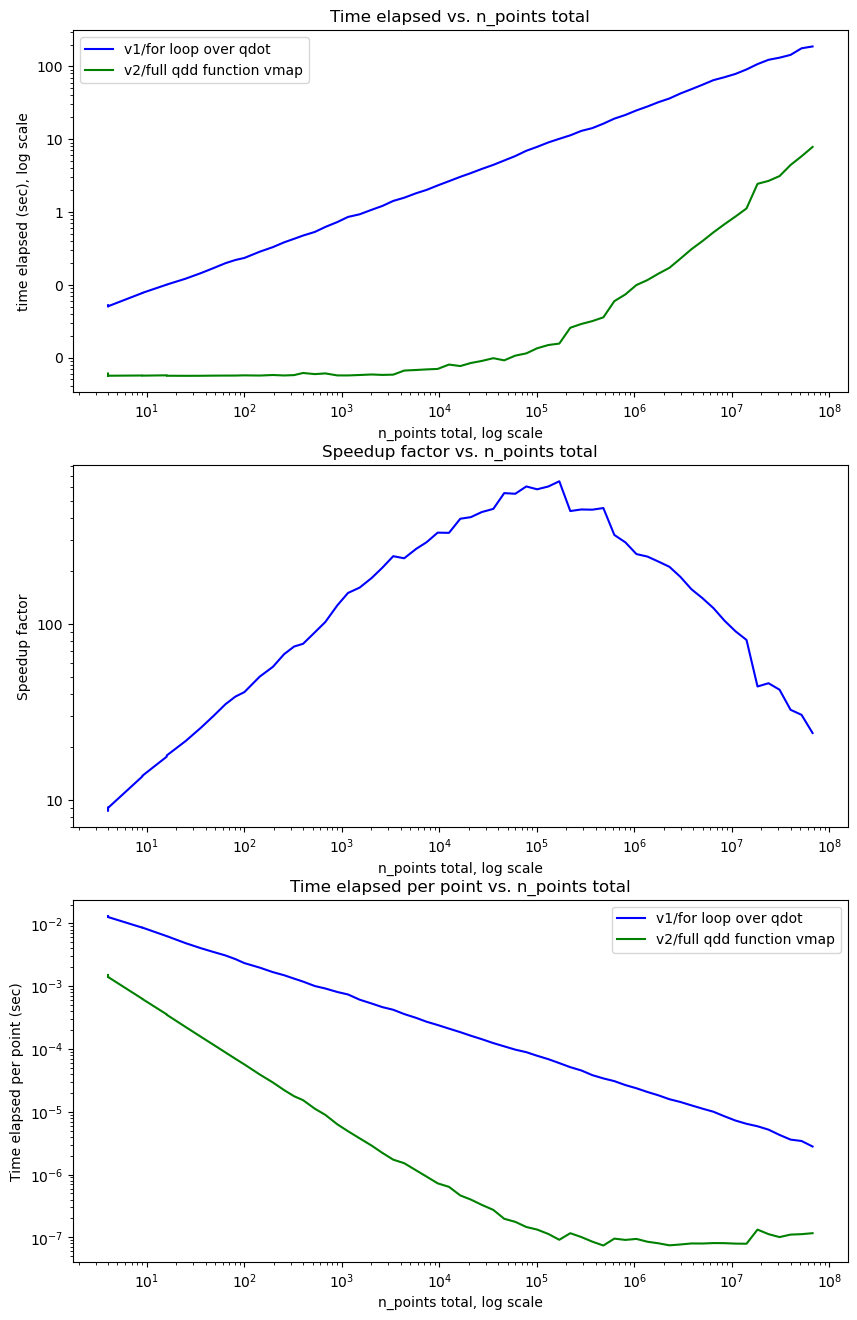

In [17]:
#####
# plotting

import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

formatter = ScalarFormatter()
formatter.set_scientific(False)

fig, axs = plt.subplots(3,1,figsize=(10,16))
axs[0].plot(n_points_array**2,ts_v1,color='blue',label='v1/for loop over qdot')
axs[0].plot(n_points_array**2,ts_v2,color='green',label='v2/full qdd function vmap')
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].set_xlabel('n_points total, log scale')
axs[0].set_ylabel('time elapsed (sec), log scale')
axs[0].set_title('Time elapsed vs. n_points total')
axs[0].legend()

axs[0].yaxis.set_major_formatter(formatter)

axs[1].plot(n_points_array**2,ts_v1/ts_v2,color='blue',label='Speedup factor')
axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].set_xlabel('n_points total, log scale')
axs[1].set_ylabel('Speedup factor')
axs[1].set_title('Speedup factor vs. n_points total')
#axs[1].legend()

axs[1].yaxis.set_major_formatter(formatter)



axs[2].plot(n_points_array**2,ts_v1/n_points_array**2,color='blue',label='v1/for loop over qdot')
axs[2].plot(n_points_array**2,ts_v2/n_points_array**2,color='green',label='v2/full qdd function vmap')
axs[2].set_xscale('log')
axs[2].set_yscale('log')
axs[2].set_xlabel('n_points total, log scale')
axs[2].set_ylabel('Time elapsed per point (sec)')
axs[2].set_title('Time elapsed per point vs. n_points total')
axs[2].legend()



plt.show()

100%|██████████| 12/12 [00:00<00:00, 197.23it/s]


Maximum speedup is (old->v2) 4484.2 at n_points per side = 362, total points = 131044


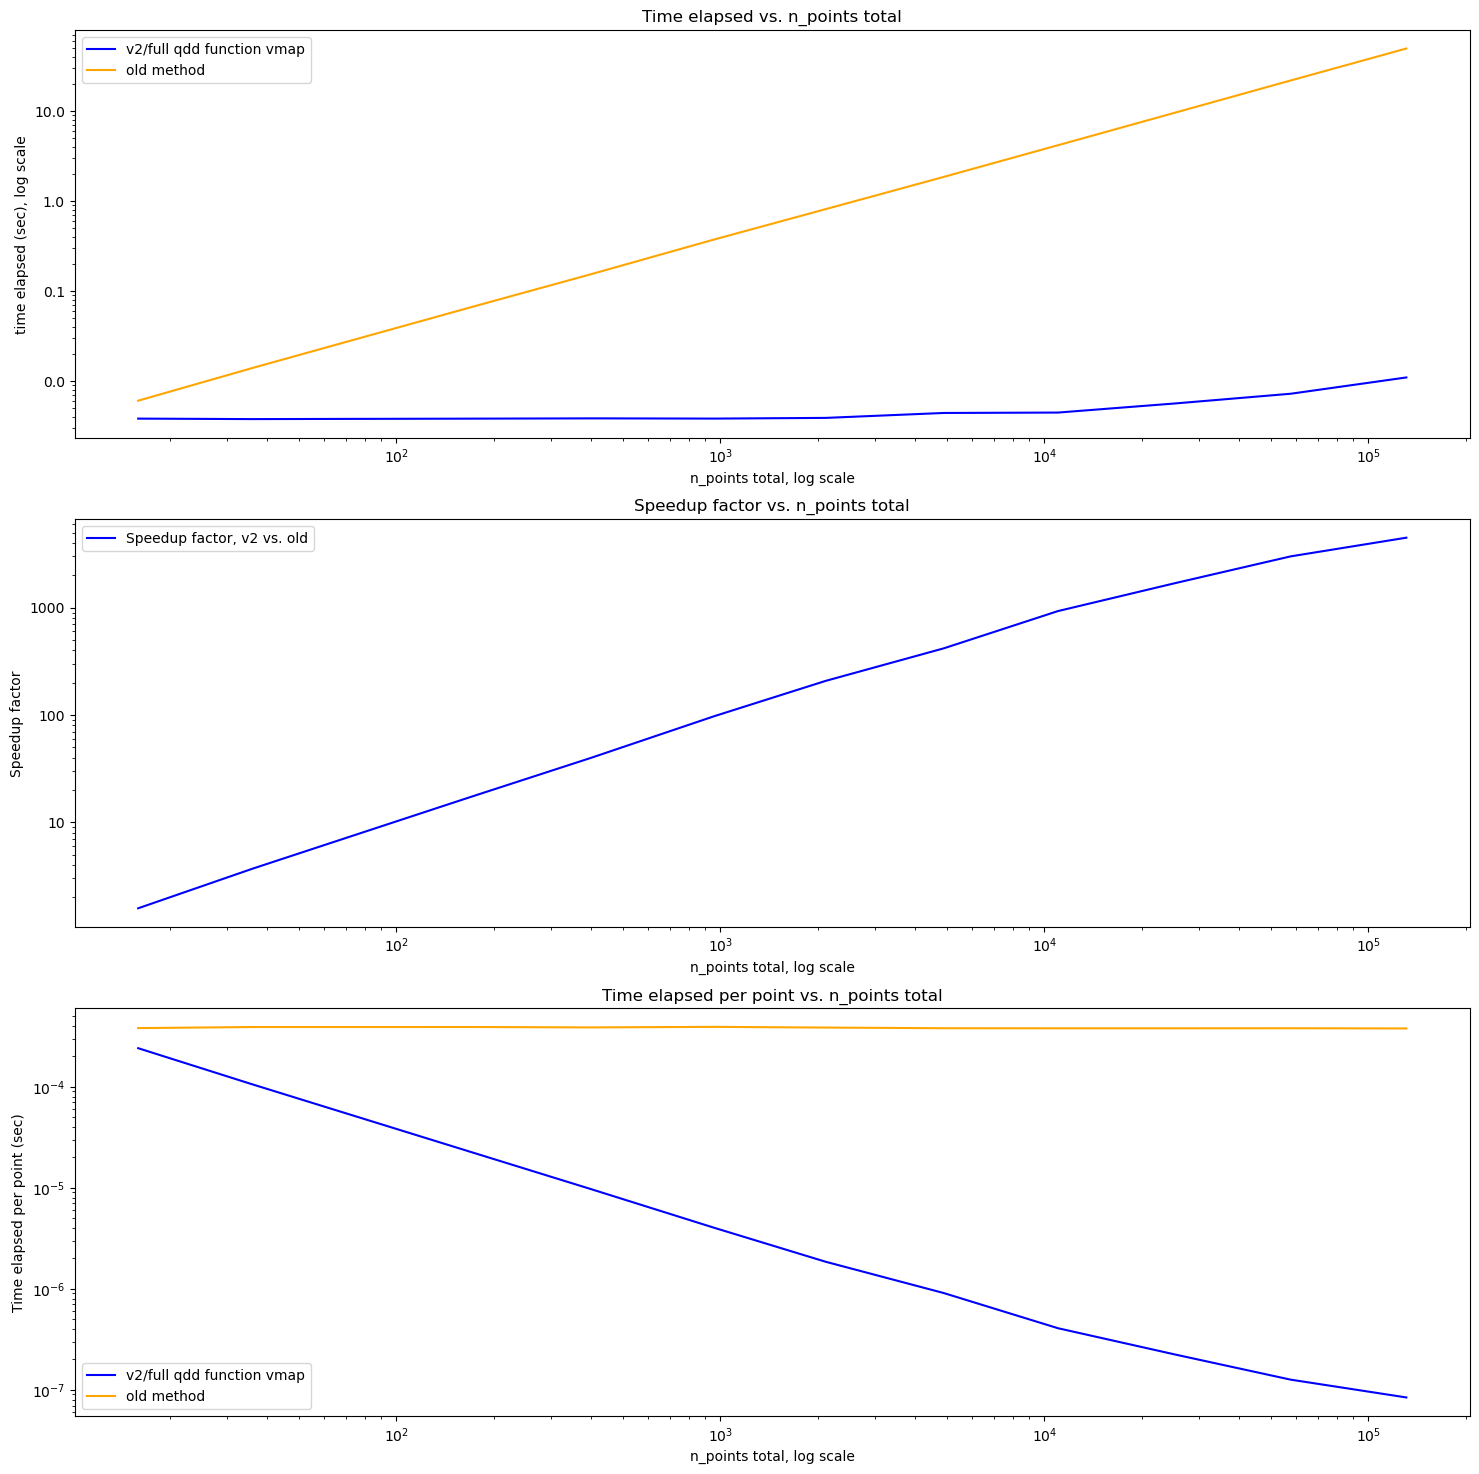

In [54]:
#speed comparisons -- including old method of autograd.hessian/jacobian

import torch
import numpy as np
import matplotlib.pyplot as plt
import tqdm
from torch.func import jacfwd, vmap
import time
from torch import tensor, cat, autograd


m = torch.tensor([1],dtype=torch.float64)
k = torch.tensor([2],dtype=torch.float64)
alpha = torch.tensor([0.0],dtype=torch.float64)

n_steps_power = 12
n_points_array_powers = np.flip(np.linspace(2,8.5,n_steps_power))
n_points_array = np.floor(2**n_points_array_powers)

q_min = -1
q_max = 1
qdot_min = -1
qdot_max = 1


#####
# global function definitions
def L(q,qdot,m,k,alpha):
    return 0.5*m*qdot**2 - 0.5*k*q**2 - alpha*q**2*qdot**2

#####
# old method function defintions

def L2(vec):
    # I know this is clunky, but I want to making the indexing simple for myself.
    #print(vec)
    m = vec[0]
    k = vec[1]
    q = vec[2]
    qdot = vec[3]

    L = 0.5*m*qdot**2 - 0.5*k*q**2
    return L

def qddot(Lag,m,k,q,qdot):
    """Returns d^2/dt^2 q given Lagrangian L"""
    v = torch.cat((m,k,q,qdot))
    #v = (m,k,q,qdot)
    full_hessian = autograd.functional.hessian(Lag,v)
    full_grad = autograd.functional.jacobian(Lag,v)
    """#debug printing functions for testing new Lagrangians
    if torch.isnan(full_hessian).max():
        print("NaN appeared in Hessian! Breaking loop!")
        return "break"
    if torch.isnan(full_grad).max():
        print("NaN appeared in Jacobian! Breaking loop!")
        return "break" """
    #print(full_grad)
    grad_q = full_grad[2]
    hess_q = full_hessian[2,2]
    hess_qdot = full_hessian[3,3]
    hess_q_qdot = full_hessian[2,3]
    qdd = (hess_qdot**(-1))*( grad_q - hess_q_qdot*qdot )
    return qdd


#####
# v1 function definition
g_q = vmap(jacfwd(L,argnums=0),in_dims=(0,None,None,None,None))
g_qdot = vmap(jacfwd(L,argnums=1),in_dims=(0,None,None,None,None))

g_q_qdot = vmap(jacfwd(jacfwd(L,argnums=1),argnums=0),in_dims=(0,None,None,None,None))
g_qdot_q = vmap(jacfwd(jacfwd(L,argnums=0),argnums=1),in_dims=(0,None,None,None,None))
g_qdot_qdot = vmap(jacfwd(jacfwd(L,argnums=1),argnums=1),in_dims=(0,None,None,None,None))

#####
# v2 function definition
g_q2 = vmap(jacfwd(L,argnums=0),in_dims=(0,None,None,None,None))
g_qdot2 = vmap(jacfwd(L,argnums=1),in_dims=(0,None,None,None,None))

g_q_qdot2 = vmap(jacfwd(jacfwd(L,argnums=1),argnums=0),in_dims=(0,None,None,None,None))
g_qdot_q2 = vmap(jacfwd(jacfwd(L,argnums=0),argnums=1),in_dims=(0,None,None,None,None))
g_qdot_qdot2 = vmap(jacfwd(jacfwd(L,argnums=1),argnums=1),in_dims=(0,None,None,None,None))

def QDD(Q,QD,m,k,alpha):
    g_q2 = jacfwd(L,argnums=0)(Q,QD,m,k,alpha)
    g_qdot2 = jacfwd(L,argnums=1)(Q,QD,m,k,alpha)
    
    g_q_qdot2 = jacfwd(jacfwd(L,argnums=1),argnums=0)(Q,QD,m,k,alpha)
    g_qdot_q2 = jacfwd(jacfwd(L,argnums=0),argnums=1)(Q,QD,m,k,alpha)
    g_qdot_qdot2 = jacfwd(jacfwd(L,argnums=1),argnums=1)(Q,QD,m,k,alpha)
    D = g_qdot_qdot2**(-1)
    return D*(g_q2 - g_q_qdot2*QD)


####
# main loops

ts_old = torch.zeros(n_steps_power)
for k in tqdm.trange(n_steps_power):
    n_points = int(n_points_array[k])

    mold = tensor([1.])
    kold = tensor([2.])
    
    out = torch.zeros([3,n_points**2]) #out[0,:] = q_i, out[1,:] = qdot_i, out[2,:] = qddot_i
    counter = -1
    qgrid = torch.linspace(q_min,q_max,n_points)
    qdotgrid = torch.linspace(qdot_min,qdot_max,n_points)

    tic_old = time.time()
    for i in range(n_points):
        for j in range(n_points):
            counter += 1
            q = tensor([qgrid[i]],requires_grad = True)
            qdot = tensor([qdotgrid[j]],requires_grad = True)
            val = qddot(L2,mold,kold,q,qdot)
            out[:,counter] = tensor([q, qdot, val])
    
    time_elapsed_old = time.time() - tic_old
    ts_old[k] = time_elapsed_old


ts_v2 = torch.zeros(n_steps_power)

for k in tqdm.trange(n_steps_power): #fast method
    n_points = int(n_points_array[k])
    qgrid = torch.linspace(q_min,q_max,n_points) #(n_points)
    qdotgrid = torch.linspace(qdot_min,qdot_max,n_points) #(n_points)
    
    #define flattened q, qdot arrays (n_points^2), (n_points^2)
    Q = qgrid.expand([n_points,n_points]).reshape(n_points**2)
    QD = qdotgrid.expand([n_points,n_points]).reshape(n_points**2)
    
    im = 0*torch.zeros([n_points,n_points])
    #print(im.shape)
    
    

    
    tic_v2 = time.time()
    
    
    QDDv = vmap(QDD,in_dims=(0,0,None,None,None))
    
    im = QDDv(Q,QD,m,k,alpha).reshape([n_points,n_points]).T
    
    t_elapsed_v2 = time.time()-tic_v2
    ts_v2[k] = t_elapsed_v2


speedup_old = ts_old/ts_v2
sp_max_old = speedup_old.max().item()
speedup_max_index_old = (speedup_old==sp_max_old)
n_max_old = int(n_points_array[speedup_max_index_old].item())



#print(sp_max_v1_old)
#print(speedup_max_index_v1_old)

print(f"Maximum speedup is (old->v2) {sp_max_old:.1f} at n_points per side = {n_max_old}, total points = {n_max_old**2}")

#####
# plotting

from matplotlib.ticker import ScalarFormatter

formatter = ScalarFormatter()
formatter.set_scientific(False)

fig, axs = plt.subplots(3,1,figsize=(18,18))
axs[0].plot(n_points_array**2,ts_v2,color='blue',label='v2/full qdd function vmap')
axs[0].plot(n_points_array**2,ts_old,color='orange',label='old method')
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].set_xlabel('n_points total, log scale')
axs[0].set_ylabel('time elapsed (sec), log scale')
axs[0].set_title('Time elapsed vs. n_points total')
axs[0].legend()
axs[0].yaxis.set_major_formatter(formatter)


axs[1].plot(n_points_array**2,ts_old/ts_v2,color='blue',label='Speedup factor, v2 vs. old')
axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].set_xlabel('n_points total, log scale')
axs[1].set_ylabel('Speedup factor')
axs[1].set_title('Speedup factor vs. n_points total')
axs[1].legend()
axs[1].yaxis.set_major_formatter(formatter)

axs[2].plot(n_points_array**2,ts_v2/n_points_array**2,color='blue',label='v2/full qdd function vmap')
axs[2].plot(n_points_array**2,ts_old/n_points_array**2,color='orange',label='old method')
axs[2].set_xscale('log')
axs[2].set_yscale('log')
axs[2].set_xlabel('n_points total, log scale')
axs[2].set_ylabel('Time elapsed per point (sec)')
axs[2].set_title('Time elapsed per point vs. n_points total')
axs[2].legend()


plt.show()

In [2]:
#speed comparisons -- including old method of autograd.hessian/jacobian

import torch
import numpy as np
import matplotlib.pyplot as plt
import tqdm
from torch.func import jacfwd, vmap
import time
from torch import tensor, cat, autograd


m = torch.tensor([1],dtype=torch.float64)
k = torch.tensor([2],dtype=torch.float64)
alpha = torch.tensor([0.0],dtype=torch.float64)

n_steps_power = 12
n_points_array_powers = np.flip(np.linspace(2,8,n_steps_power))
n_points_array = np.floor(2**n_points_array_powers)

q_min = -1
q_max = 1
qdot_min = -1
qdot_max = 1


#####
# global function definitions
def L(q,qdot,m,k,alpha):
    return 0.5*m*qdot**2 - 0.5*k*q**2 - alpha*q**2*qdot**2

#####
# old method function defintions

def L2(vec):
    # I know this is clunky, but I want to making the indexing simple for myself.
    #print(vec)
    m = vec[0]
    k = vec[1]
    q = vec[2]
    qdot = vec[3]

    L = 0.5*m*qdot**2 - 0.5*k*q**2
    return L

def qddot(Lag,m,k,q,qdot):
    """Returns d^2/dt^2 q given Lagrangian L"""
    v = torch.cat((m,k,q,qdot))
    #v = (m,k,q,qdot)
    full_hessian = autograd.functional.hessian(Lag,v)
    full_grad = autograd.functional.jacobian(Lag,v)
    """#debug printing functions for testing new Lagrangians
    if torch.isnan(full_hessian).max():
        print("NaN appeared in Hessian! Breaking loop!")
        return "break"
    if torch.isnan(full_grad).max():
        print("NaN appeared in Jacobian! Breaking loop!")
        return "break" """
    #print(full_grad)
    grad_q = full_grad[2]
    hess_q = full_hessian[2,2]
    hess_qdot = full_hessian[3,3]
    hess_q_qdot = full_hessian[2,3]
    qdd = (hess_qdot**(-1))*( grad_q - hess_q_qdot*qdot )
    return qdd


#####
# v1 function definition
g_q = vmap(jacfwd(L,argnums=0),in_dims=(0,None,None,None,None))
g_qdot = vmap(jacfwd(L,argnums=1),in_dims=(0,None,None,None,None))

g_q_qdot = vmap(jacfwd(jacfwd(L,argnums=1),argnums=0),in_dims=(0,None,None,None,None))
g_qdot_q = vmap(jacfwd(jacfwd(L,argnums=0),argnums=1),in_dims=(0,None,None,None,None))
g_qdot_qdot = vmap(jacfwd(jacfwd(L,argnums=1),argnums=1),in_dims=(0,None,None,None,None))

#####
# v2 function definition
g_q2 = vmap(jacfwd(L,argnums=0),in_dims=(0,None,None,None,None))
g_qdot2 = vmap(jacfwd(L,argnums=1),in_dims=(0,None,None,None,None))

g_q_qdot2 = vmap(jacfwd(jacfwd(L,argnums=1),argnums=0),in_dims=(0,None,None,None,None))
g_qdot_q2 = vmap(jacfwd(jacfwd(L,argnums=0),argnums=1),in_dims=(0,None,None,None,None))
g_qdot_qdot2 = vmap(jacfwd(jacfwd(L,argnums=1),argnums=1),in_dims=(0,None,None,None,None))

def QDD(Q,QD,m,k,alpha):
    g_q2 = jacfwd(L,argnums=0)(Q,QD,m,k,alpha)
    g_qdot2 = jacfwd(L,argnums=1)(Q,QD,m,k,alpha)
    
    g_q_qdot2 = jacfwd(jacfwd(L,argnums=1),argnums=0)(Q,QD,m,k,alpha)
    g_qdot_q2 = jacfwd(jacfwd(L,argnums=0),argnums=1)(Q,QD,m,k,alpha)
    g_qdot_qdot2 = jacfwd(jacfwd(L,argnums=1),argnums=1)(Q,QD,m,k,alpha)
    D = g_qdot_qdot2**(-1)
    return D*(g_q2 - g_q_qdot2*QD)


####
# main loops

ts_old = torch.zeros(n_steps_power)
for k in tqdm.trange(n_steps_power):
    n_points = int(n_points_array[k])

    mold = tensor([1.])
    kold = tensor([2.])
    
    out = torch.zeros([3,n_points**2]) #out[0,:] = q_i, out[1,:] = qdot_i, out[2,:] = qddot_i
    counter = -1
    qgrid = torch.linspace(q_min,q_max,n_points)
    qdotgrid = torch.linspace(qdot_min,qdot_max,n_points)

    tic_old = time.time()
    for i in range(n_points):
        for j in range(n_points):
            counter += 1
            q = tensor([qgrid[i]],requires_grad = True)
            qdot = tensor([qdotgrid[j]],requires_grad = True)
            val = qddot(L2,mold,kold,q,qdot)
            out[:,counter] = tensor([q, qdot, val])
    
    time_elapsed_old = time.time() - tic_old
    ts_old[k] = time_elapsed_old

ts_v1 = torch.zeros(n_steps_power)

for k in tqdm.trange(n_steps_power):
    n_points = int(n_points_array[k])
    qgrid = torch.linspace(q_min,q_max,n_points)
    qdotgrid = torch.linspace(qdot_min,qdot_max,n_points)
    Q = torch.tensor([])
    QD = torch.tensor([])
    im = 0*torch.zeros([n_points,n_points])
    #print(im.shape)
    
    tic_for = time.time()
    
    
    for j in range(n_points):
        t_g_q = g_q(qgrid,qdotgrid[j],m,k,alpha)
        t_g_q_qdot = g_q_qdot(qgrid,qdotgrid[j],m,k,alpha)
        t_g_qdot_q = g_qdot_q(qgrid,qdotgrid[j],m,k,alpha)
        t_g_qdot_qdot = g_qdot_qdot(qgrid,qdotgrid[j],m,k,alpha)
        
        D = t_g_qdot_qdot**(-1)
    
        temp = torch.squeeze(D*(t_g_q - t_g_q_qdot*qdotgrid[j]))
        #print(temp)
        #print(temp.shape)
        #print(im[:,j].shape)
        #print(im[j,:].expand([1,50]))
        im[:,j] = torch.squeeze(D*(t_g_q - t_g_q_qdot*qdotgrid[j]))
        #print(im[:,j])
    
    t_elapsed_for = time.time()-tic_for
    ts_v1[k] = t_elapsed_for

ts_v2 = torch.zeros(n_steps_power)

for k in tqdm.trange(n_steps_power): #fast method
    n_points = int(n_points_array[k])
    qgrid = torch.linspace(q_min,q_max,n_points) #(n_points)
    qdotgrid = torch.linspace(qdot_min,qdot_max,n_points) #(n_points)
    
    #define flattened q, qdot arrays (n_points^2), (n_points^2)
    Q = qgrid.expand([n_points,n_points]).reshape(n_points**2)
    QD = qdotgrid.expand([n_points,n_points]).reshape(n_points**2)
    
    im = 0*torch.zeros([n_points,n_points])
    #print(im.shape)
    
    

    
    tic_v2 = time.time()
    
    
    QDDv = vmap(QDD,in_dims=(0,0,None,None,None))
    
    im = QDDv(Q,QD,m,k,alpha).reshape([n_points,n_points]).T
    
    t_elapsed_v2 = time.time()-tic_v2
    ts_v2[k] = t_elapsed_v2


speedup = ts_v1/ts_v2
sp_max = speedup.max().item()
speedup_max_index = (speedup==sp_max)
n_max = int(n_points_array[speedup_max_index].item())

speedup_old = ts_old/ts_v2
sp_max_old = speedup_old.max().item()
speedup_max_index_old = (speedup_old==sp_max_old)
n_max_old = int(n_points_array[speedup_max_index_old].item())

speedup_v1_old = ts_old/ts_v1
sp_max_v1_old = speedup_v1_old.max().item()
speedup_max_index_v1_old = (speedup_v1_old==sp_max_v1_old)
n_max_v1_old = int(n_points_array[speedup_max_index_v1_old].item())

#print(sp_max_v1_old)
#print(speedup_max_index_v1_old)

print(f"Maximum speedup is (v1->v2) {sp_max:.1f} at n_points per side = {n_max}, total points = {n_max**2}")
print(f"Maximum speedup is (old->v1) {sp_max_v1_old:.1f} at n_points per side = {n_max_v1_old}, total points = {n_max_v1_old**2}")
print(f"Maximum speedup is (old->v2) {sp_max_old:.1f} at n_points per side = {n_max_old}, total points = {n_max_old**2}")

100%|██████████| 10/10 [00:00<00:00, 249.78it/s]

Maximum speedup is (v1->v2) 67.0 at n_points per side = 64, total points = 4096
Maximum speedup is (old->v1) 6.0 at n_points per side = 64, total points = 4096
Maximum speedup is (old->v2) 404.1 at n_points per side = 64, total points = 4096


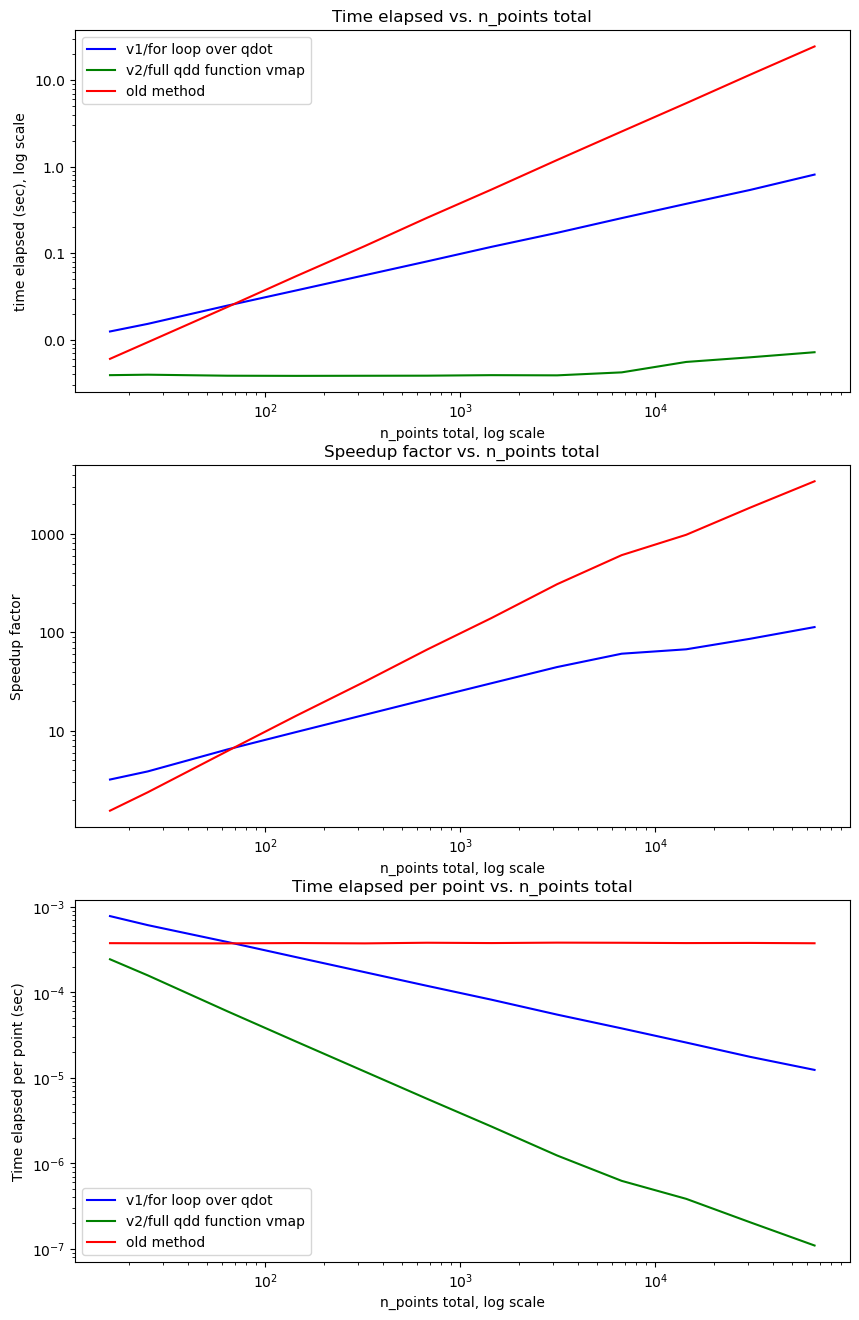

In [44]:
#####
# plotting

import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

formatter = ScalarFormatter()
formatter.set_scientific(False)

fig, axs = plt.subplots(3,1,figsize=(10,16))
axs[0].plot(n_points_array**2,ts_v1,color='blue',label='v1/for loop over qdot')
axs[0].plot(n_points_array**2,ts_v2,color='green',label='v2/full qdd function vmap')
axs[0].plot(n_points_array**2,ts_old,color='red',label='old method')
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].set_xlabel('n_points total, log scale')
axs[0].set_ylabel('time elapsed (sec), log scale')
axs[0].set_title('Time elapsed vs. n_points total')
axs[0].legend()

axs[0].yaxis.set_major_formatter(formatter)

axs[1].plot(n_points_array**2,ts_v1/ts_v2,color='blue',label='Speedup factor, v2 vs. v1')
axs[1].plot(n_points_array**2,ts_old/ts_v2,color='red',label='Speedup factor, v2 vs. old')

axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].set_xlabel('n_points total, log scale')
axs[1].set_ylabel('Speedup factor')
axs[1].set_title('Speedup factor vs. n_points total')
#axs[1].legend()

axs[1].yaxis.set_major_formatter(formatter)



axs[2].plot(n_points_array**2,ts_v1/n_points_array**2,color='blue',label='v1/for loop over qdot')
axs[2].plot(n_points_array**2,ts_v2/n_points_array**2,color='green',label='v2/full qdd function vmap')
axs[2].plot(n_points_array**2,ts_old/n_points_array**2,color='red',label='old method')
axs[2].set_xscale('log')
axs[2].set_yscale('log')
axs[2].set_xlabel('n_points total, log scale')
axs[2].set_ylabel('Time elapsed per point (sec)')
axs[2].set_title('Time elapsed per point vs. n_points total')
axs[2].legend()



plt.show()

In [ ]:
#testing Q/QD array testing methods -- running into slowdowns here using old naive method.
#

n_steps = 20
n_test = 10
n_points_powers = np.flip(np.linspace(2,10,n_steps))
n_points_array = 2**n_points_powers

t_naive = np.zeros([n_steps,n_test])
t_better = np.zeros([n_steps,n_test])

for i in tqdm.trange(n_steps):
    for j in range(n_test):
        n_points = int(n_points_array[i])
        qgrid = torch.linspace(q_min,q_max,n_points) #(n_points)
        qdotgrid = torch.linspace(qdot_min,qdot_max,n_points) #(n_points)
    
        tic_array1 = time.time()
        #define flattened q, qdot arrays (n_points^2), (n_points^2)
        Q = torch.tensor([])
        QD = torch.tensor([])
    
        for k in range(n_points):
            Q = torch.concat((Q,qgrid))
            QD = torch.concat((QD,qdotgrid[k]*torch.ones(n_points)))
        t_e_array1 = time.time() - tic_array1
    
        
        tic_array2 = time.time()
        Q = qgrid.expand([n_points,n_points]).reshape(n_points**2)
        QD = qdotgrid.expand([n_points,n_points]).reshape(n_points**2)
        t_e_array2 = time.time() - tic_array2
    
        t_naive[i,j] = t_e_array1
        t_better[i,j] = t_e_array2

t_naive_mean = t_naive.mean(axis=1)
t_better_mean = t_better.mean(axis=1)
t_naive_stdev = t_naive.std(axis=1)
t_better_stdev = t_better.std(axis=1)

speedup= t_naive/t_better
sp_max = np.max(speedup)
index_max = speedup == sp_max
for i in range(n_test):
    if len(n_points_array[index_max[:,i]]) != 0:
        n_best = int(n_points_array[index_max[:,i]].item())
sp_min = np.min(speedup)
index_min = speedup == sp_min
for i in range(n_test):
    if len(n_points_array[index_min[:,i]]) != 0:
        n_worst = int(n_points_array[index_min[:,i]].item())

print(f"The maximum speedup is {int(sp_max)} at n = {n_best}.")
print(f"The minimum speedup is {int(sp_min)} at n = {n_worst}.")


plt.plot(n_points_array,t_naive[:,0],color='blue',label='naive concat method')
for i in range(1,n_test):
    plt.plot(n_points_array,t_naive[:,i],color='blue')
    
plt.plot(n_points_array,t_better[:,0],color='green',label='torch.expand.reshape method')
for i in range(1,n_test):
    plt.plot(n_points_array,t_better[:,i],color='green')

plt.xlabel('n points')
plt.ylabel('time (sec)')
plt.xscale('log')
plt.yscale('log')
plt.title('Naive vs. torch Q/QD creation')
plt.legend()



plt.show()

  0%|          | 0/20 [00:00<?, ?it/s]

In [306]:
Q

tensor([-1.0000, -0.9980, -0.9961,  ...,  0.9961,  0.9980,  1.0000])

In [308]:
Q = torch.tensor([])
QD = torch.tensor([])

for k in range(n_points):
    Q = torch.concat((Q,qgrid))
    QD = torch.concat((QD,qdotgrid[k]*torch.ones(n_points)))

print(Q)

tensor([-1.0000, -0.9980, -0.9961,  ...,  0.9961,  0.9980,  1.0000])


In [302]:
Q

tensor([-1.0000, -0.3333,  0.3333,  1.0000, -1.0000, -0.3333,  0.3333,  1.0000,
        -1.0000, -0.3333,  0.3333,  1.0000, -1.0000, -0.3333,  0.3333,  1.0000])

100%|██████████| 13/13 [03:02<00:00, 14.01s/it]


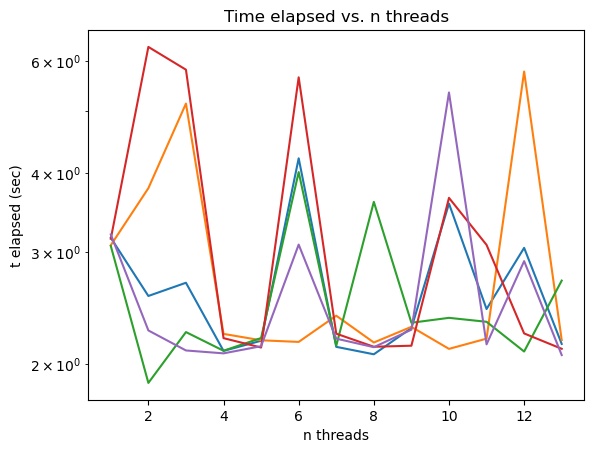

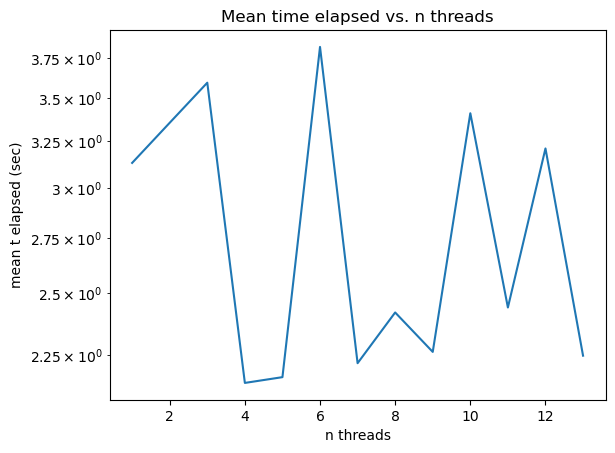

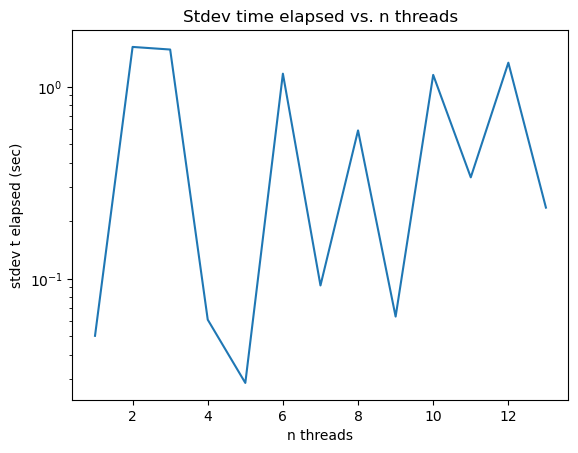

In [94]:
#####
# characterizing multithreading for a fixed number of points

import torch
import numpy as np
import matplotlib.pyplot as plt
import tqdm
from torch.func import jacfwd, vmap
import time
import random

m = torch.tensor([1],dtype=torch.float64)
k = torch.tensor([2],dtype=torch.float64)
alpha = torch.tensor([0.0],dtype=torch.float64)

n_points = 2000
q_min = -1
q_max = 1
qdot_min = -1
qdot_max = 1

n_test = 5
threads = np.arange(1,14,1)

#####
# function definitions

def L(q,qdot,m,k,alpha):
    return 0.5*m*qdot**2 - 0.5*k*q**2 - alpha*q**2*qdot**2

g_q2 = vmap(jacfwd(L,argnums=0),in_dims=(0,None,None,None,None))
g_qdot2 = vmap(jacfwd(L,argnums=1),in_dims=(0,None,None,None,None))

g_q_qdot2 = vmap(jacfwd(jacfwd(L,argnums=1),argnums=0),in_dims=(0,None,None,None,None))
g_qdot_q2 = vmap(jacfwd(jacfwd(L,argnums=0),argnums=1),in_dims=(0,None,None,None,None))
g_qdot_qdot2 = vmap(jacfwd(jacfwd(L,argnums=1),argnums=1),in_dims=(0,None,None,None,None))

def QDD(Q,QD,m,k,alpha):
    g_q2 = jacfwd(L,argnums=0)(Q,QD,m,k,alpha)
    g_qdot2 = jacfwd(L,argnums=1)(Q,QD,m,k,alpha)
    
    g_q_qdot2 = jacfwd(jacfwd(L,argnums=1),argnums=0)(Q,QD,m,k,alpha)
    g_qdot_q2 = jacfwd(jacfwd(L,argnums=0),argnums=1)(Q,QD,m,k,alpha)
    g_qdot_qdot2 = jacfwd(jacfwd(L,argnums=1),argnums=1)(Q,QD,m,k,alpha)
    D = g_qdot_qdot2**(-1)
    return D*(g_q2 - g_q_qdot2*QD)

QDDv = vmap(QDD,in_dims=(0,0,None,None,None))


#####
# preprocessing
threads_size = threads.size
runtimes = np.zeros([threads_size,n_test])

# randomly shuffling execution order to mitigate background process effects
threads_array = np.arange(0,threads_size,1) 
random.shuffle(threads_array)
test_array = np.arange(0,n_test,1)
random.shuffle(test_array)

qgrid = torch.linspace(q_min,q_max,n_points) #(n_points)
qdotgrid = torch.linspace(qdot_min,qdot_max,n_points) #(n_points)

#define flattened q, qdot arrays (n_points^2), (n_points^2)
Q = torch.tensor([])
QD = torch.tensor([])

for i in range(n_points):
    Q = torch.concat((Q,qgrid))
    QD = torch.concat((QD,qdotgrid[i]*torch.ones(n_points)))

#####
# main computation
for t_ in tqdm.trange(threads_size):
    for k_ in range(n_test):
        t = threads_array[t_] #mapping from iterable to shuffled arrays
        k = test_array[k_]
        torch.set_num_threads(threads[t])
        tic_v2 = time.time()
        
        
    
        im = QDDv(Q,QD,m,k,alpha).reshape([n_points,n_points]).T
        
        t_elapsed_v2 = time.time()-tic_v2
        runtimes[t,k] = t_elapsed_v2
    
#print(runtimes)

for i in range(n_test):
    plt.plot(threads,runtimes[:,i])
plt.yscale('log')
plt.xlabel('n threads')
plt.ylabel('t elapsed (sec)')
plt.title('Time elapsed vs. n threads')

plt.show()

plt.plot(threads,runtimes.mean(axis=1))
plt.yscale('log')
plt.xlabel('n threads')
plt.ylabel('mean t elapsed (sec)')
plt.title('Mean time elapsed vs. n threads')
plt.show()

plt.plot(threads,runtimes.std(axis=1))
plt.yscale('log')
plt.xlabel('n threads')
plt.ylabel('stdev t elapsed (sec)')
plt.title('Stdev time elapsed vs. n threads')
plt.show()


100%|██████████| 20/20 [00:14<00:00,  1.42it/s]


Maximum speedup is (fwd->rev) 3.3 at n_points per side = 4, total points = 16


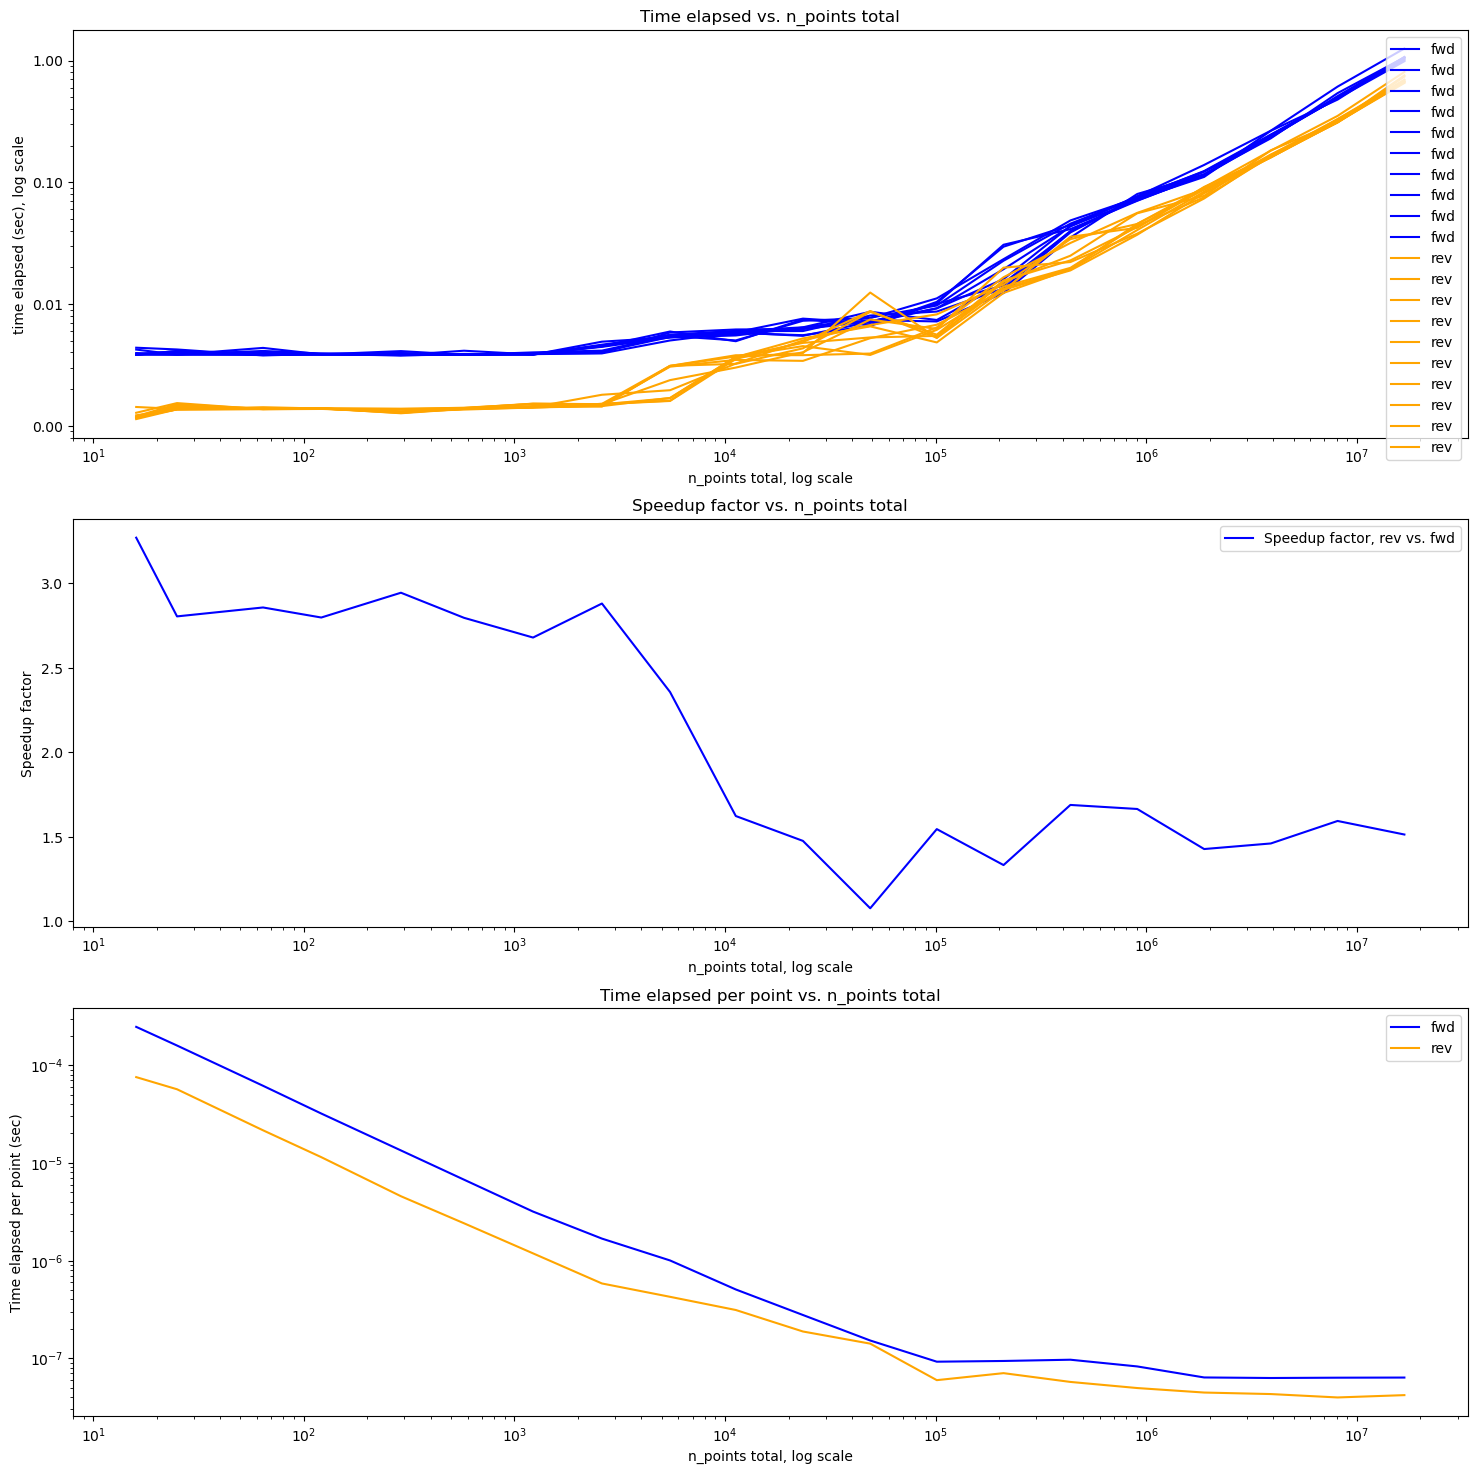

In [1]:
#comparing jacfwd vs jacrev

#speed comparisons -- including old method of autograd.hessian/jacobian

import torch
import numpy as np
import matplotlib.pyplot as plt
import tqdm
from torch.func import jacfwd, jacrev, vmap
import time
from torch import tensor, cat, autograd


m = torch.tensor([1],dtype=torch.float64)
k = torch.tensor([2],dtype=torch.float64)
alpha = torch.tensor([0.0],dtype=torch.float64)

n_steps_power = 20
n_points_array_powers = np.flip(np.linspace(2,12,n_steps_power))
n_points_array = np.floor(2**n_points_array_powers)

n_trials = 10

q_min = -1
q_max = 1
qdot_min = -1
qdot_max = 1


#####
# global function definitions
def L(q,qdot,m,k,alpha):
    return 0.5*m*qdot**2 - 0.5*k*q**2 - alpha*q**2*qdot**2


def QDDf(Q,QD,m,k,alpha):
    g_q = jacfwd(L,argnums=0)(Q,QD,m,k,alpha)
    g_qdot = jacfwd(L,argnums=1)(Q,QD,m,k,alpha)
    
    g_q_qdot = jacfwd(jacfwd(L,argnums=1),argnums=0)(Q,QD,m,k,alpha)
    g_qdot_q = jacfwd(jacfwd(L,argnums=0),argnums=1)(Q,QD,m,k,alpha)
    g_qdot_qdot = jacfwd(jacfwd(L,argnums=1),argnums=1)(Q,QD,m,k,alpha)
    D = g_qdot_qdot**(-1)
    return D*(g_q - g_q_qdot*QD)
    
QDDfv = vmap(QDDf,in_dims=(0,0,None,None,None))

def QDDr(Q,QD,m,k,alpha):
    g_q = jacrev(L,argnums=0)(Q,QD,m,k,alpha)
    g_qdot = jacrev(L,argnums=1)(Q,QD,m,k,alpha)
    
    g_q_qdot = jacrev(jacrev(L,argnums=1),argnums=0)(Q,QD,m,k,alpha)
    g_qdot_q = jacrev(jacrev(L,argnums=0),argnums=1)(Q,QD,m,k,alpha)
    g_qdot_qdot = jacrev(jacrev(L,argnums=1),argnums=1)(Q,QD,m,k,alpha)
    D = g_qdot_qdot**(-1)
    return D*(g_q - g_q_qdot*QD)
    
QDDrv = vmap(QDDr,in_dims=(0,0,None,None,None))

####
# main loops

ts_f = torch.zeros(n_steps_power,n_trials)

for k in tqdm.trange(n_steps_power): #fast method
    for j in range(n_trials):
        n_points = int(n_points_array[k])
        qgrid = torch.linspace(q_min,q_max,n_points) #(n_points)
        qdotgrid = torch.linspace(qdot_min,qdot_max,n_points) #(n_points)
        
        #define flattened q, qdot arrays (n_points^2), (n_points^2)
        Q = qgrid.expand([n_points,n_points]).reshape(n_points**2)
        QD = qdotgrid.expand([n_points,n_points]).reshape(n_points**2)
    
        tic_f = time.time()
    
        im = QDDfv(Q,QD,m,k,alpha).reshape([n_points,n_points]).T
        
        t_elapsed_f = time.time()-tic_f
        ts_f[k,j] = t_elapsed_f


ts_r = torch.zeros(n_steps_power,n_trials)

for k in tqdm.trange(n_steps_power): #fast method
    for j in range(n_trials):
        n_points = int(n_points_array[k])
        qgrid = torch.linspace(q_min,q_max,n_points) #(n_points)
        qdotgrid = torch.linspace(qdot_min,qdot_max,n_points) #(n_points)
        
        #define flattened q, qdot arrays (n_points^2), (n_points^2)
        Q = qgrid.expand([n_points,n_points]).reshape(n_points**2)
        QD = qdotgrid.expand([n_points,n_points]).reshape(n_points**2)
    
        tic_r = time.time()
    
        im = QDDrv(Q,QD,m,k,alpha).reshape([n_points,n_points]).T
        
        t_elapsed_r = time.time()-tic_r
        ts_r[k,j] = t_elapsed_r

ts_f_m = torch.mean(ts_f,axis=1)
ts_r_m = torch.mean(ts_r,axis=1)

speedup = ts_f_m/ts_r_m
sp_max = speedup.max().item()
speedup_max_index = (speedup==sp_max)
n_max = int(n_points_array[speedup_max_index].item())



#print(sp_max_v1_old)
#print(speedup_max_index_v1_old)

print(f"Maximum speedup is (fwd->rev) {sp_max:.1f} at n_points per side = {n_max}, total points = {n_max**2}")

#####
# plotting

from matplotlib.ticker import ScalarFormatter

formatter = ScalarFormatter()
formatter.set_scientific(False)

fig, axs = plt.subplots(3,1,figsize=(18,18))
axs[0].plot(n_points_array**2,ts_f,color='blue',label='fwd')
axs[0].plot(n_points_array**2,ts_r,color='orange',label='rev')
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].set_xlabel('n_points total, log scale')
axs[0].set_ylabel('time elapsed (sec), log scale')
axs[0].set_title('Time elapsed vs. n_points total')
axs[0].legend()
axs[0].yaxis.set_major_formatter(formatter)


axs[1].plot(n_points_array**2,ts_f_m/ts_r_m,color='blue',label='Speedup factor, rev vs. fwd')
axs[1].set_xscale('log')
#axs[1].set_yscale('log')
axs[1].set_xlabel('n_points total, log scale')
axs[1].set_ylabel('Speedup factor')
axs[1].set_title('Speedup factor vs. n_points total')
axs[1].legend()
#axs[1].yaxis.set_major_formatter(formatter)

axs[2].plot(n_points_array**2,ts_f_m/n_points_array**2,color='blue',label='fwd')
axs[2].plot(n_points_array**2,ts_r_m/n_points_array**2,color='orange',label='rev')
axs[2].set_xscale('log')
axs[2].set_yscale('log')
axs[2].set_xlabel('n_points total, log scale')
axs[2].set_ylabel('Time elapsed per point (sec)')
axs[2].set_title('Time elapsed per point vs. n_points total')
axs[2].legend()


plt.show()